#Modules

In [209]:
import pandas as pd
import numpy as np

In [210]:
pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [211]:
from __future__ import print_function
import numpy as np
import h5py
import glob
import math
from sklearn import metrics 
from keras.metrics import accuracy
import warnings
warnings.filterwarnings('ignore')
import os
import shutil
from scipy import signal
from scipy.signal import butter, lfilter
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Dropout, Reshape 
from keras.layers import Bidirectional, BatchNormalization, ZeroPadding1D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from keras import regularizers
from keras.layers import (Dense, Dropout, Activation, Flatten, Reshape, Layer,
                          BatchNormalization, LocallyConnected2D, AveragePooling1D,
                          ZeroPadding2D, Conv2D, MaxPooling2D, Conv2DTranspose,
                          GaussianNoise, UpSampling2D, Input, InputSpec)
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from keras.initializers import VarianceScaling
from keras.callbacks import CSVLogger
from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics 
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')

#Loading of data

In [294]:
df = pd.read_parquet('/content/drive/MyDrive/TB06_data/r206n05.gzip')


In [295]:
df.head()

,timestamp,avg:ambient,var:ambient,max:ambient,min:ambient,avg:dimm0_temp,var:dimm0_temp,max:dimm0_temp,min:dimm0_temp,avg:dimm10_temp,...,avg:swap_free,var:swap_free,max:swap_free,min:swap_free,avg:swap_total,var:swap_total,max:swap_total,min:swap_total,label,New_label
index,,,,,,,,,,,,,,,,,,,,,
27,2020-06-01 00:15:00,21.353846,0.101026,21.8,20.8,30.076923,0.076923,31,30,29.0,...,3593600.0,0.0,3593600,3593600,4194240,0.0,4194240,4194240,0,0
30,2020-06-01 00:30:00,21.384615,0.189744,22.0,20.8,30.230769,0.192308,31,30,29.0,...,3593702.4,1228.8,3593728,3593664,4194240,0.0,4194240,4194240,0,0
33,2020-06-01 00:45:00,21.169231,0.078974,21.6,20.8,30.000000,0.000000,30,30,29.0,...,3593792.0,0.0,3593792,3593792,4194240,0.0,4194240,4194240,0,0
36,2020-06-01 01:00:00,21.615385,0.083077,22.0,21.0,30.384615,0.256410,31,30,29.0,...,3593920.0,0.0,3593920,3593920,4194240,0.0,4194240,4194240,0,0
39,2020-06-01 01:15:00,21.153846,0.174359,21.8,20.6,30.000000,0.000000,30,30,29.0,...,3593984.0,0.0,3593984,3593984,4194240,0.0,4194240,4194240,0,0


In [296]:
df = df.drop(['label','timestamp'],axis=1)

In [297]:
df.describe()


,avg:ambient,var:ambient,max:ambient,min:ambient,avg:dimm0_temp,var:dimm0_temp,max:dimm0_temp,min:dimm0_temp,avg:dimm10_temp,var:dimm10_temp,...,min:proc_total,avg:swap_free,var:swap_free,max:swap_free,min:swap_free,avg:swap_total,var:swap_total,max:swap_total,min:swap_total,New_label
count,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,...,15310.000000,1.531000e+04,1.531000e+04,1.531000e+04,1.531000e+04,15310.0,15310.0,15310.0,15310.0,15310.000000
mean,18.716309,0.041324,18.940888,18.489288,27.082400,0.073318,27.264533,26.897257,27.616306,0.062888,...,2461.721816,3.586335e+06,5.954080e+08,3.587052e+06,3.585617e+06,4194240.0,0.0,4194240.0,4194240.0,0.049510
std,2.482816,0.097875,2.505538,2.466572,2.421890,0.142473,2.452004,2.409420,2.378890,0.161412,...,554.162798,4.641056e+05,2.908237e+10,4.617490e+05,4.674183e+05,0.0,0.0,0.0,0.0,0.310766
min,10.426667,0.000000,10.600000,10.000000,20.266667,0.000000,21.000000,20.000000,20.000000,0.000000,...,1235.000000,7.561143e+03,0.000000e+00,1.664000e+04,0.000000e+00,4194240.0,0.0,4194240.0,4194240.0,0.000000
25%,16.986667,0.008381,17.200000,16.800000,25.000000,0.000000,25.000000,25.000000,26.000000,0.000000,...,2093.000000,3.279424e+06,0.000000e+00,3.279424e+06,3.279424e+06,4194240.0,0.0,4194240.0,4194240.0,0.000000
50%,18.586667,0.014095,18.800000,18.400000,27.000000,0.000000,27.000000,27.000000,28.000000,0.000000,...,2240.500000,3.600128e+06,0.000000e+00,3.600128e+06,3.600128e+06,4194240.0,0.0,4194240.0,4194240.0,0.000000
75%,20.613333,0.036952,21.000000,20.200000,29.000000,0.123810,29.000000,29.000000,29.000000,0.066667,...,2698.000000,4.194240e+06,0.000000e+00,4.194240e+06,4.194240e+06,4194240.0,0.0,4194240.0,4194240.0,0.000000
max,25.226667,4.300952,25.400000,25.200000,33.000000,4.409524,33.000000,33.000000,33.933333,8.638095,...,3804.000000,4.194240e+06,1.835336e+12,4.194240e+06,4.194240e+06,4194240.0,0.0,4194240.0,4194240.0,2.000000


In [298]:
df.isna().any()


avg:ambient       False
var:ambient       False
max:ambient       False
min:ambient       False
avg:dimm0_temp    False
                  ...  
avg:swap_total    False
var:swap_total    False
max:swap_total    False
min:swap_total    False
New_label         False
Length: 461, dtype: bool

In [299]:
df.isnull().sum()


avg:ambient       0
var:ambient       0
max:ambient       0
min:ambient       0
avg:dimm0_temp    0
                 ..
avg:swap_total    0
var:swap_total    0
max:swap_total    0
min:swap_total    0
New_label         0
Length: 461, dtype: int64

In [300]:
X = df.drop('New_label',axis=1)
y = df.New_label

In [301]:
y

index
27       0
30       0
33       0
36       0
39       0
        ..
96180    0
96183    0
96186    0
96189    0
96192    0
Name: New_label, Length: 15310, dtype: int64

In [302]:
y = y.apply(lambda x: 1 if x == 2 else 0)


In [303]:
y[y==1]

index
3015     1
3018     1
3021     1
3024     1
3027     1
        ..
95211    1
95214    1
95217    1
95220    1
95223    1
Name: New_label, Length: 379, dtype: int64

In [304]:
a, b=y.value_counts()

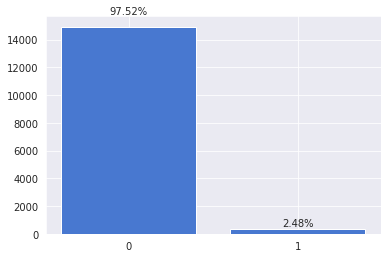

In [305]:
a_perc = round((a / y.value_counts().sum()) * 100, 2)
b_perc= round((b / y.value_counts().sum()) * 100, 2)
bar_label=[str(a_perc)+'%', str(b_perc)+'%']

fig, ax = plt.subplots()
bar_tick_label=['0','1']
bar_plot = plt.bar(y.unique(), y.value_counts(), tick_label=bar_tick_label)
def autolabel(rects):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0)

autolabel(bar_plot)

In [306]:
X.shape

(15310, 460)

In [307]:
from sklearn.preprocessing import MinMaxScaler

columns = list(X.columns.values)
scaler = MinMaxScaler() 
X[columns] = scaler.fit_transform(X[columns])
X.head()

,avg:ambient,var:ambient,max:ambient,min:ambient,avg:dimm0_temp,var:dimm0_temp,max:dimm0_temp,min:dimm0_temp,avg:dimm10_temp,var:dimm10_temp,...,max:proc_total,min:proc_total,avg:swap_free,var:swap_free,max:swap_free,min:swap_free,avg:swap_total,var:swap_total,max:swap_total,min:swap_total
index,,,,,,,,,,,,,,,,,,,,,
27,0.738323,0.023489,0.756757,0.710526,0.770439,0.017445,0.833333,0.769231,0.645933,0.0,...,0.304531,0.309848,0.856535,0.000000e+00,0.856224,0.856794,0.0,0.0,0.0,0.0
30,0.740402,0.044117,0.770270,0.710526,0.782521,0.043612,0.833333,0.769231,0.645933,0.0,...,0.306068,0.309848,0.856560,6.695233e-10,0.856254,0.856809,0.0,0.0,0.0,0.0
33,0.725849,0.018362,0.743243,0.710526,0.764398,0.000000,0.750000,0.769231,0.645933,0.0,...,0.304531,0.310237,0.856581,0.000000e+00,0.856270,0.856840,0.0,0.0,0.0,0.0
36,0.755994,0.019316,0.770270,0.723684,0.794603,0.058149,0.833333,0.769231,0.645933,0.0,...,0.306068,0.310627,0.856612,0.000000e+00,0.856300,0.856870,0.0,0.0,0.0,0.0
39,0.724809,0.040540,0.756757,0.697368,0.764398,0.000000,0.750000,0.769231,0.645933,0.0,...,0.305300,0.308680,0.856627,0.000000e+00,0.856316,0.856886,0.0,0.0,0.0,0.0


In [308]:
X.shape


(15310, 460)

In [309]:
y.shape

(15310,)

#Model

In [310]:
X = np.expand_dims(X, axis=2)

In [311]:
# X = np.expand_dims(X, axis=3)

In [312]:
X.shape

(15310, 460, 1)

In [313]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

In [314]:
Pre_train_optimizer = SGD(learning_rate=0.1, momentum=0.9)


##Autoencoder

In [315]:
# Conv1 #
input_img = Input(shape=(460, 1, 1))  
x = Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D(pool_size = (2, 2), padding='same')(x)

# Conv2 #
x = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size = (2, 2), padding='same')(x) 

# Conv 3 #
x = Conv2D(filters = 8, kernel_size =(3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D(pool_size = (2, 2), padding='same')(x)

# Note:
# padding is a hyper-arameter for either 'valid' or 'same'. 
# "valid" means "no padding". 
# "same" results in padding the input such that the output has the same length as the original input.
############
# Decoding #
############

# DeConv1
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

# DeConv2
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

# Deconv3
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [316]:
# from keras import backend as K 
# def euc_dist_keras(y_true, y_pred):
#     return K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1, keepdims=True))

In [317]:
autoencoder = Model(input_img, decoded)
encoder =Model(input_img, encoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

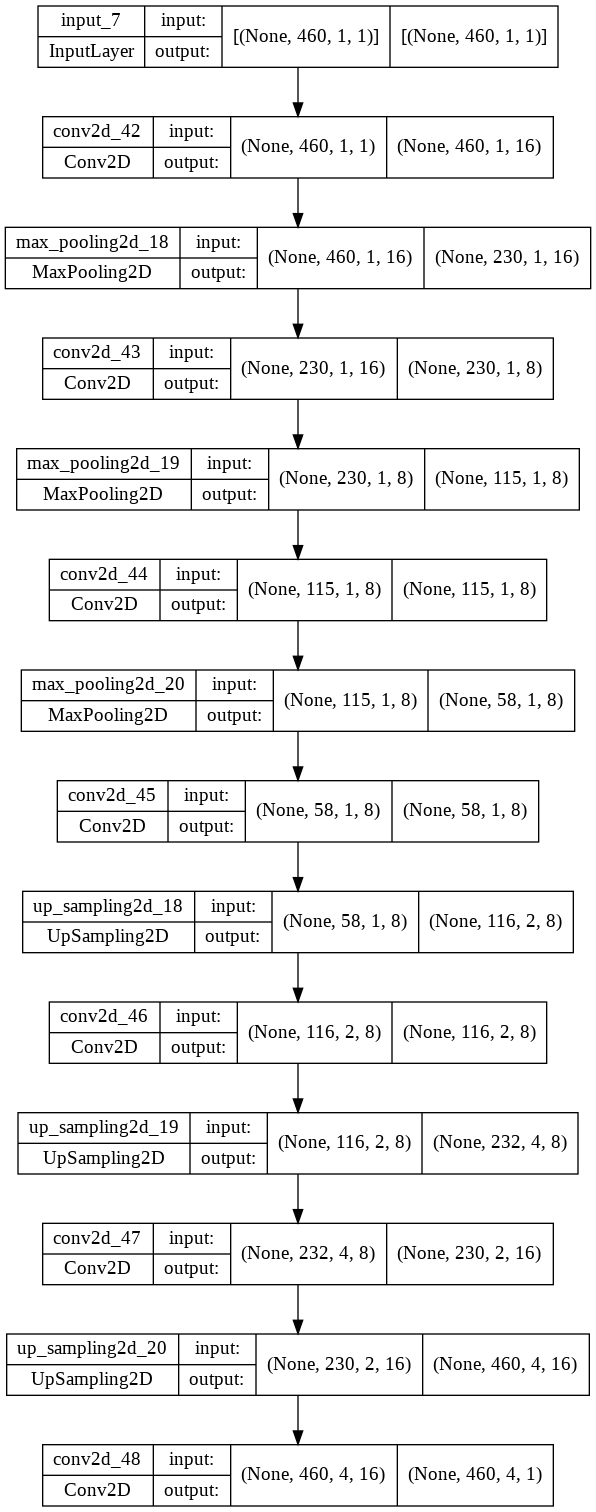

In [318]:
from tensorflow.keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='autoencoder.png')

In [319]:
from keras.callbacks import TensorBoard
path = '/content/drive/MyDrive/TB06_data/results'
history=autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=128,
                verbose=1,
                shuffle=True,
                validation_batch_size=64,
                validation_data=(X_test, X_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])
                #)



Epoch 1/100
96/96 [==============================] - 2s 12ms/step - loss: 0.5951 - accuracy: 0.1873 - val_loss: 0.5263 - val_accuracy: 0.1877
Epoch 2/100
96/96 [==============================] - 1s 9ms/step - loss: 0.5093 - accuracy: 0.1865 - val_loss: 0.4953 - val_accuracy: 0.1824
Epoch 3/100
96/96 [==============================] - 1s 9ms/step - loss: 0.4755 - accuracy: 0.1886 - val_loss: 0.4560 - val_accuracy: 0.1956
Epoch 4/100
96/96 [==============================] - 1s 9ms/step - loss: 0.4383 - accuracy: 0.1984 - val_loss: 0.4260 - val_accuracy: 0.1984
Epoch 5/100
96/96 [==============================] - 1s 9ms/step - loss: 0.4161 - accuracy: 0.2001 - val_loss: 0.4094 - val_accuracy: 0.2003
Epoch 6/100
96/96 [==============================] - 1s 9ms/step - loss: 0.4036 - accuracy: 0.2006 - val_loss: 0.4003 - val_accuracy: 0.2000
Epoch 7/100
96/96 [==============================] - 1s 9ms/step - loss: 0.3970 - accuracy: 0.2008 - val_loss: 0.3956 - val_accuracy: 0.1999
Epoch 8/100


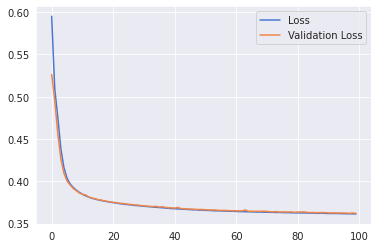

In [320]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

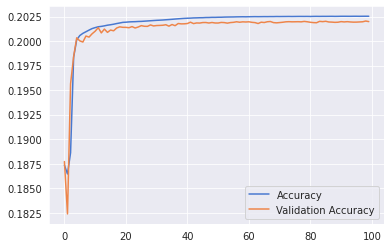

In [321]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [322]:
autoencoder.save_weights(path + '/ae_weights_conv.h5')


In [323]:
autoencoder = Model(input_img, decoded)
encoder =Model(input_img, encoded)

In [324]:
autoencoder.load_weights('/content/drive/MyDrive/TB06_data/results/ae_weights_conv.h5')


In [325]:
pred = autoencoder.predict(X_test)

In [326]:
pred.shape

(3062, 460, 4, 1)

In [327]:
pred=pred.reshape(3062,460*4)

In [328]:
pred.shape

(3062, 1840)

#Kmeans and PCA

In [329]:
score = []
range_values = range(1, 20)
for i in range_values:
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(pred)
    score.append([int(i),kmeans.inertia_])
score=np.array(score).reshape(-1,2)



##Elbow plot

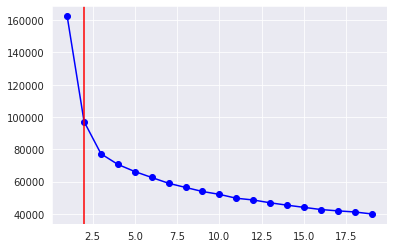

In [330]:
plt.plot(score[:,0], score[:, 1], 'bo-')
plt.axvline(x=2, c='r')

In [331]:
kmeans = KMeans(2, n_init=20)
kmeans.fit(pred)
labels = kmeans.labels_

In [361]:
labels.shape

(3062,)

##PCA -  2 components

In [365]:
pca = PCA(n_components = 2)
prin_comp = pca.fit_transform(pred)
pca_df = pd.DataFrame(data = prin_comp, columns = ['pca1', 'pca2'])

In [366]:
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster': labels})], axis = 1)
pca_df.head()

,pca1,pca2,cluster
0,-1.944005,-2.690537,0
1,-1.919509,-0.201086,0
2,-0.837794,-4.294449,0
3,-8.659512,3.906398,0
4,-4.093056,-0.111320,0


Text(0, 0.5, 'pca2')

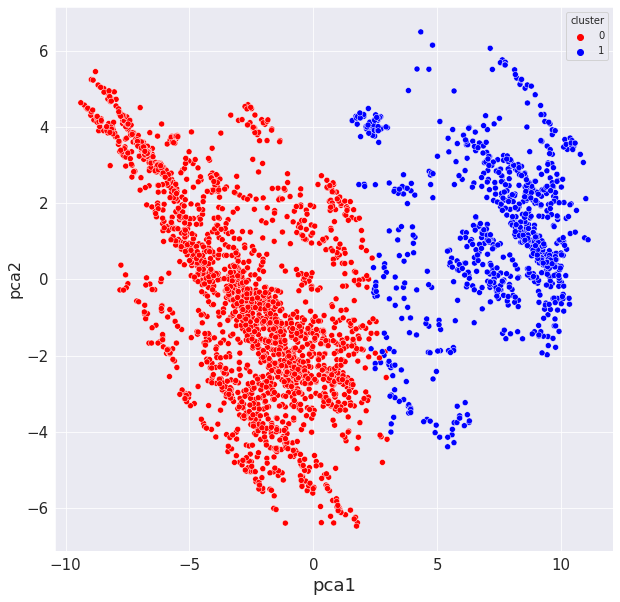

In [367]:
plt.figure(figsize = (10, 10))
ax = sns.scatterplot(x = 'pca1', y = 'pca2', hue = 'cluster', data = pca_df, palette = ['red', 'blue'] )
ax.tick_params(axis='both', which='major', labelsize = 15)
plt.xlabel('pca1', fontsize=18)
plt.ylabel('pca2', fontsize=16)

##PCA - 3 components 

In [368]:
pca_3d = PCA(n_components = 3)
prin_comp = pca_3d.fit_transform(pred)
pca_df_3d = pd.DataFrame(data = prin_comp, columns = ['pca1', 'pca2', 'pca3'])

In [369]:
pca_df_3d = pd.concat([pca_df_3d, pd.DataFrame({'cluster': labels})], axis = 1)
pca_df_3d.head()

,pca1,pca2,pca3,cluster
0,-1.944028,-2.690539,-0.542804,0
1,-1.919508,-0.201082,-2.276403,0
2,-0.837795,-4.294450,0.639875,0
3,-8.659511,3.906396,0.661008,0
4,-4.093057,-0.111318,-2.699312,0


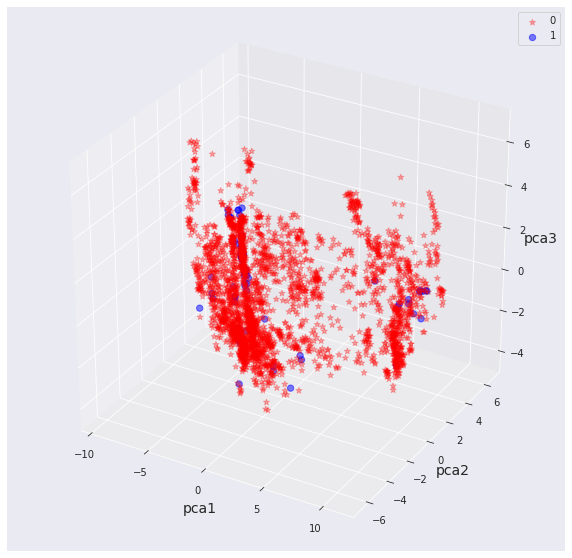

In [370]:
# pca_3d = PCA(n_components=3)
# pca_3d.fit(pred) 
# X_pca = pca_3d.transform(pred) 

ex_variance=np.var(prin_comp,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
ex_variance_ratio


Xax = prin_comp[:,0]
Yax = prin_comp[:,1]
Zax = prin_comp[:,2]

cdict = {0:'red',1:'blue'}
labl = {0:'0', 1:'1'}
marker = {0:'*',1:'o'}
alpha = {0:.3, 1:.5}

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

fig.patch.set_facecolor('white')
for l in np.unique(y_test):
 ix=np.where(y_test==l)
 ax.scatter(Xax[ix], Yax[ix], Zax[ix], c=cdict[l], s=40,
           label=labl[l], marker=marker[l], alpha=alpha[l])
# for loop ends
ax.set_xlabel("pca1", fontsize=14)
ax.set_ylabel("pca2", fontsize=14)
ax.set_zlabel("pca3", fontsize=14)

ax.legend()
plt.show()


#Evaluation

##Accuracy

In [371]:
labels.shape

(3062,)

In [372]:
X_test.shape

(3062, 460)

In [373]:
X_test=X_test.reshape(3062, 460*1)

##Confusion Matrix

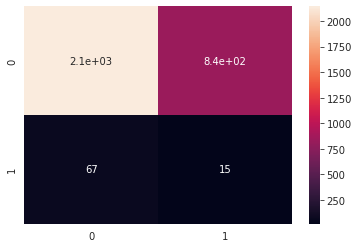

In [383]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(y_test, labels)
sns.heatmap(cm, annot=True)

In [354]:
# #The mean is the most accurate way of deriving the central tendencies of a group of values, 
# #not only because it gives a more precise value as an answer, but also because it takes into account every value in the list.
# pred_avg=pred.mean(axis=1)

In [355]:
# pred_avg.shape

(3062,)

In [358]:
# X=X.reshape(15310, 460*1)

##Silhouette_score

In [384]:
from sklearn.metrics import  normalized_mutual_info_score, adjusted_rand_score, silhouette_score, silhouette_samples

score = silhouette_score(X_test, labels, metric='euclidean')
print ("For n_clusters = 2, Deep clustering silhouette score is {})".format(score))

For n_clusters = 2, Deep clustering silhouette score is 0.4109467358900993)


In [386]:
from plot_silhouette import plot_silhouette

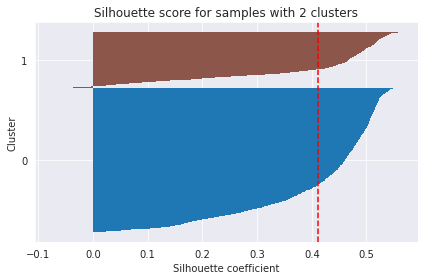

In [387]:
cluster_labels = np.unique(labels)
n_clusters = cluster_labels.shape[0] # it is the number of rows
# Compute the Silhouette Coefficient for each sample, with the euclidean metric
silhouette_score_samples = silhouette_samples(X_test, labels, metric='euclidean')
plt.title('Silhouette score for samples with {} clusters'.format(2))
plot_silhouette(silhouette_score_samples, labels)

This slhouette score means that the point is on average closer to points in another cluster than to points in its own cluster.

##Normalized_mutual_info_score

In [382]:
from numpy.lib.function_base import average
print(normalized_mutual_info_score(y_test, labels, average_method='geometric'))


0.002488899716672232
